# Pairs Trading 
>  https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import coint

np.random.seed(107)



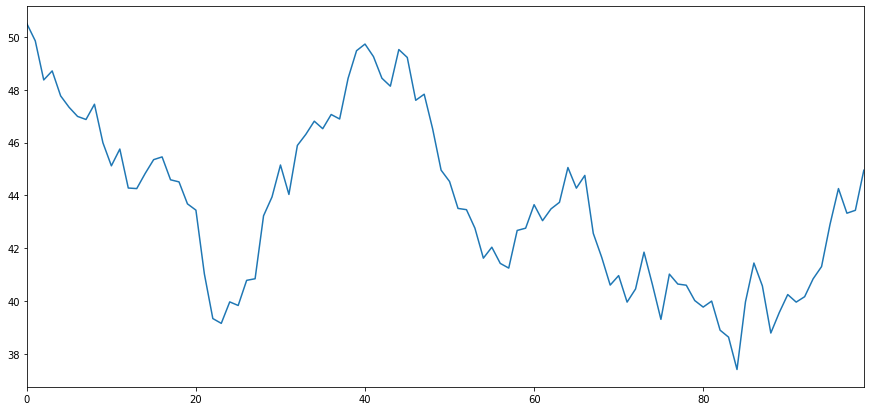

In [2]:
Xreturns = np.random.normal(0, 1, 100)

X = pd.Series(np.cumsum(Xreturns), name = 'X') + 50
X.plot(figsize = (15, 7))
plt.show()

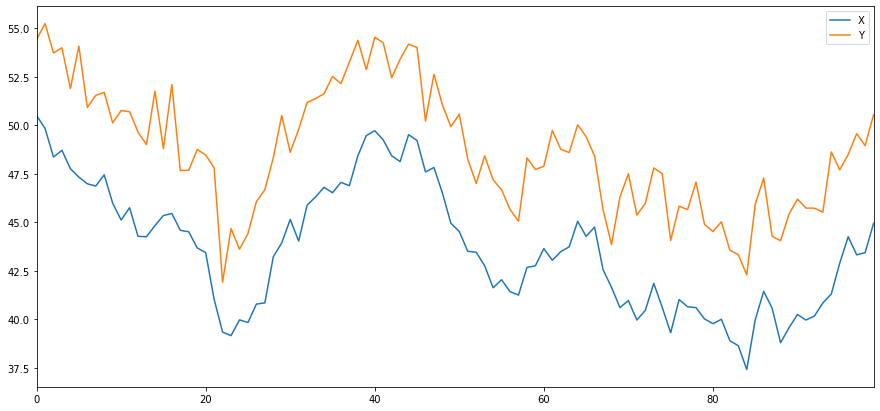

In [4]:
noise = np.random.normal(0, 1,100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis = 1).plot(figsize = (15, 7))

plt.show()

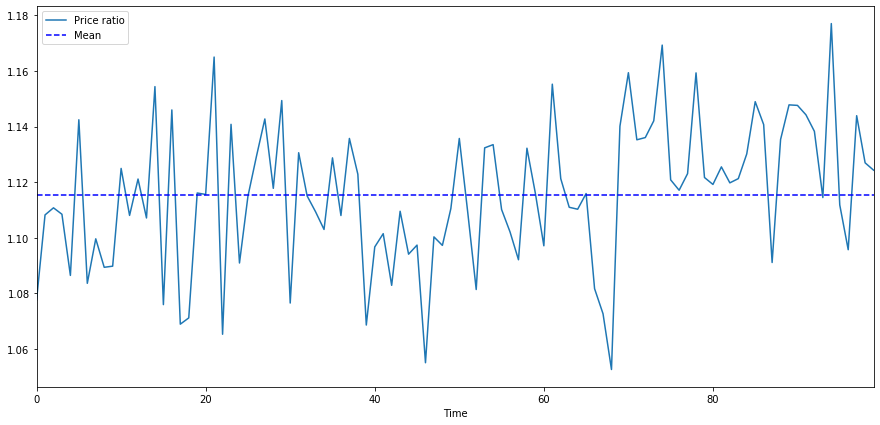

In [6]:
(Y/X).plot(figsize = (15,7))
plt.axhline((Y/X).mean(), color = 'blue', linestyle = '--')

plt.xlabel("Time")
plt.legend(['Price ratio', 'Mean'])
plt.show()

In [7]:
score, pvalue, _ = coint(X, Y)
print(pvalue)

2.0503418653412224e-16


In [8]:
X.corr(Y)

0.9497090646385932

*Difference between cointegration and cointegrated*

### Multiple comparisons bias

The fact that there is an increased chance to incorrectly generate a significant p-value when many tests are run. If 100 tests are run on random data, we should expect to see 5-pvalues below 0.005.

**To avoid this, pick a small number of pairs**

In [18]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score, pvalue_matrix, pairs
            

We include the market benchmark (SPX) in our data — the market drives the movement of so many securities that often you might find two seemingly cointegrated securities; but in reality they are not cointegrated with each other but both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.

In [5]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource

In [6]:
from datetime import datetime

In [36]:
start_date = '2007/12/01'
end_date = '2017/12/01'
cachedFolderName = 'YahooData/'
dataSetId = 'pairstrading'
instrumentIds = ['SPY', 'AAPL', 'EBAY', 'MSFT', 'INTC', 'IBM']

*没有NVDA，AMD？*

In [37]:
ds = YahooStockDataSource(cachedFolderName=cachedFolderName, dataSetId=dataSetId, instrumentIds=instrumentIds, startDateStr= start_date, endDateStr=end_date, event = 'history')

data = ds.getBookDataByFeature()['adjClose']

data.head(3)

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: INTC
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


,SPY,AAPL,EBAY,MSFT,INTC,IBM
2007-12-03,115.354126,22.299068,13.715061,24.943430,18.237839,75.560249
2007-12-04,114.323051,22.417509,13.706738,24.829779,18.279516,76.131424
2007-12-05,116.236794,23.126902,13.881558,25.875401,18.911764,77.223793


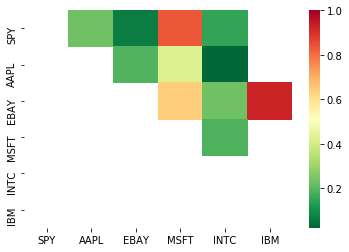

[]


In [38]:
# Heatmap to show cointegrattion and p-value

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn as sns
m = [0, 0.2, 0.4, 0.6, 0.8, 1]
sns.heatmap(pvalues, xticklabels = instrumentIds, yticklabels = instrumentIds, cmap = 'RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()
print(pairs)

The absolue ratio(S1/S2) isn't very useful in statistical terms. It is more helpful to normalzie oru siganle by treating it as a Z-score.

$Z-score = \frac{Value - Mean}{Standard Deviation}$

**In practice this is usually done to try to give some scale to the data, but this assumes an underlying distribution. Usually normal. However, much financial data is not normally distributed, and we must be very careful not to simply assume normality, or any specific distribution when generating statistics. The true distribution of ratios could be very fat-tailed and prone to extreme values messing up our model and resulting in large losses.**

### Cointegration

In [1]:
import numpy as np
import pandas as pd
import seaborn
import statsmodels
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [2]:
np.random.seed(100)

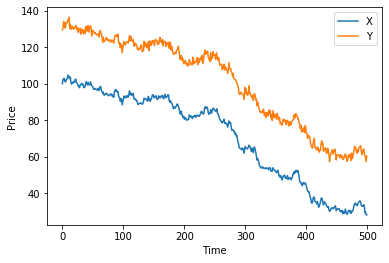

In [6]:
x = np.random.normal(0, 1, 500)
y = np.random.normal(0, 1, 500)
X = pd.Series(np.cumsum(x)) + 100
Y = X + y + 30

for i in range(500):
    X[i] = X[i] - i/10
    Y[i] = Y[i] - i/10
plt.plot(X);
plt.plot(Y);
plt.xlabel('Time');
plt.ylabel('Price');
plt.legend(["X", "Y"]);

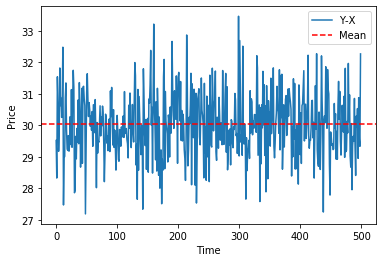

In [8]:
plt.plot(Y-X);
plt.axhline((Y-X).mean(), color = 'red', linestyle = '--')
plt.xlabel('Time');
plt.ylabel('Price');
plt.legend(['Y-X', 'Mean'])

In [9]:
# Strategy

In [10]:
# p值越低，协整关系就越强
# p低于0.05， 协整关系就非常强
import statsmodels.api as sm

def find_cointegrated(df):
    # length of dataframe
    n = df.shape[1]
    pvalue_matrix = np.one((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = df[keys[i]]
            stock2 = df[keys[j]]
            
            result = sm.tsa.stattools.coint(stock1, stock2)
            
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append(keys[i],keys[j], pvalue)
    return pvalue_matrix, pairs

In [12]:
stock_list = ["002142.XSHE", "600000.XSHG", "600015.XSHG", "600016.XSHG", "600036.XSHG", "601009.XSHG",
              "601166.XSHG", "601169.XSHG", "601328.XSHG", "601398.XSHG", "601988.XSHG", "601998.XSHG"]
prices_df = get_price(stock_list, start_date="2014-01-01", end_date="2015-01-01", frequency="daily", fields=["close"])["close"]
pvalues, pairs = find_cointegrated_pairs(prices_df)
sns.heatmap(1-pvalues, xticklabels=stock_list, yticklabels=stock_list, cmap='RdYlGn_r', mask = (pvalues == 1))


NameError: name 'get_price' is not defined